In [5]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [6]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [7]:
IMPORTANCE = (0.7 ** torch.arange(0, 20)).to(device)

In [8]:
class ToyModel(nn.Module):
    def __init__(self, m, n, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x): # x is 5 * 1
        # print("w", self.weights)
        # print("x", x)
        hidden = self.weights @ x
        # print("hidden", hidden)
        final = self.weights.T @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [9]:
def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((20,1), probability))
            x = torch.rand(batch_size, 20, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

### Graph weights as heatmap

In [144]:
def graph_weights(weights, bias):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3.5)) # 1 row, 2 columns
    
    w = weights.clone().cpu().detach()
    to_graph = w.T @ w
    colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
    n_bins = 100 
    cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
    
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    axs[0].imshow(to_graph, cmap=cm, norm=norm)
    # ax = plt.gca()
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    graph_biases(bias, axs[1])
    plt.subplots_adjust(left=0.0, right=1.4)
    plt.tight_layout()
    plt.show()

def graph_biases(bias, ax_obj):
  b = bias.clone().detach().cpu()
  colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
  n_bins = 100 
  cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
  
  norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
  
  ax_obj.imshow(b, cmap=cm, norm=norm)

  ax_obj.set_xticks([])
  ax_obj.set_yticks([])


### Graph superposition

In [149]:
def get_superposition_scores(w):
  rv = torch.zeros(20,)
  for i in range(20):
    current_vector = w[i] / torch.norm(w[i])
    the_sum = sum((w @ current_vector.reshape(5, 1)) ** 2)
    the_sum -= (current_vector.reshape(1, 5) @ w[i]) ** 2
    rv[i] = the_sum
  return torch.clamp(rv, max=1)

def graph_superposition(weights):
  w = weights.T.clone().detach().to('cpu')
  categories = [str(i) for i in range(20)]
  super_scores = get_superposition_scores(w).numpy()
  colors = [(0, (i)*(136 /255), (i) * (255/255)) for i in super_scores]
  normed_weights = torch.norm(w, dim=1).numpy()

  plt.barh(categories, normed_weights[::-1], color=colors[::-1], height=1.0)
  plt.axis('off')

  plt.show()


## Training linear model

In [47]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 2000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [48]:
model_0_sparsity = ToyModel(5, 20, False).to(device)

In [49]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_0_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 13.842857469916344
(EPOCH: 2) --> loss: 1.0533535557687284
(EPOCH: 3) --> loss: 0.35140590929985044
(EPOCH: 4) --> loss: 0.18546878892928362
(EPOCH: 5) --> loss: 0.11876310168579221
(EPOCH: 6) --> loss: 0.08521280893869698
(EPOCH: 7) --> loss: 0.06186920288950205
(EPOCH: 8) --> loss: 0.04773891006596386
(EPOCH: 9) --> loss: 0.04649249793216586
(EPOCH: 10) --> loss: 0.046475054724141956


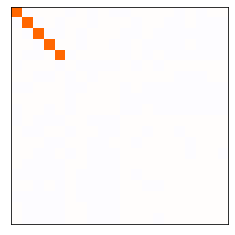

In [50]:
graph_weights(model_0_sparsity.weights)

## Training ReLU Model (0 sparsity)

In [54]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 2000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [55]:
model_0_sparsity_relu = ToyModel(5, 20, True).to(device)

In [56]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_0_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 10.766251503407956
(EPOCH: 2) --> loss: 1.5236820839047431
(EPOCH: 3) --> loss: 0.9780914185345173
(EPOCH: 4) --> loss: 0.8278457116782665
(EPOCH: 5) --> loss: 0.6160252014994622
(EPOCH: 6) --> loss: 0.4967609033957124
(EPOCH: 7) --> loss: 0.14626913760602475
(EPOCH: 8) --> loss: 0.08215297842212022
(EPOCH: 9) --> loss: 0.05461258794367314
(EPOCH: 10) --> loss: 0.049700586959719656


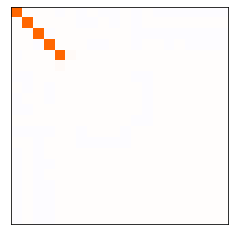

In [57]:
graph_weights(model_0_sparsity_relu.weights)

## Training ReLU Model (70% sparsity)

In [84]:
NUM_EPOCHS = 20
BATCHS_PER_EPOCH = 2000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3

In [85]:
model_70_sparsity_relu = ToyModel(5, 20, True).to(device)

In [86]:
SPARSITY = 0.70
optimizer = torch.optim.Adam(model_70_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_70_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 6.523690735599841
(EPOCH: 2) --> loss: 0.6754082028447592
(EPOCH: 3) --> loss: 0.3181354773049534
(EPOCH: 4) --> loss: 0.2696320567087678
(EPOCH: 5) --> loss: 0.2340356259973778
(EPOCH: 6) --> loss: 0.176900561203307
(EPOCH: 7) --> loss: 0.1410988673696047
(EPOCH: 8) --> loss: 0.11656451015638596
(EPOCH: 9) --> loss: 0.0843777176887088
(EPOCH: 10) --> loss: 0.05999339758668793
(EPOCH: 11) --> loss: 0.05251670080702752
(EPOCH: 12) --> loss: 0.0478038125038147
(EPOCH: 13) --> loss: 0.04707775749231223
(EPOCH: 14) --> loss: 0.047859911659848875
(EPOCH: 15) --> loss: 0.046207906221039596
(EPOCH: 16) --> loss: 0.045584003267926165
(EPOCH: 17) --> loss: 0.046308274738141336
(EPOCH: 18) --> loss: 0.04602162983117159
(EPOCH: 19) --> loss: 0.046371702406555415
(EPOCH: 20) --> loss: 0.04795091515313834


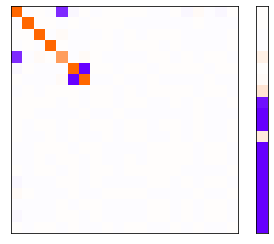

In [145]:
graph_weights(model_70_sparsity_relu.weights, model_70_sparsity_relu.bias)

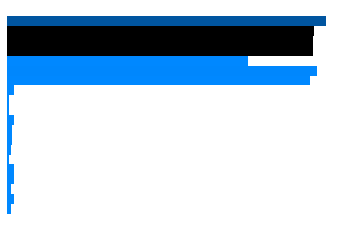

In [150]:
graph_superposition(model_70_sparsity_relu.weights)

## Training ReLU Model (90% sparsity)

In [16]:
model_90_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.90
optimizer = torch.optim.SGD(model_90_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_90_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 0.1285799600426356


In [ ]:
graph_weights(model_90_sparsity_relu.weights)

# Training ReLU Model (97% sparsity)

In [ ]:
model_97_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.97
optimizer = torch.optim.SGD(model_97_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_97_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_97_sparsity_relu.weights)

# Training ReLU Model (99% sparsity)

In [ ]:
model_99_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.99
optimizer = torch.optim.SGD(model_99_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_99_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_99_sparsity_relu.weights)

## Training ReLU Model (99.7 % sparsity)

In [ ]:
model_997_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.997
optimizer = torch.optim.SGD(model_997_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_997_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_997_sparsity_relu.weights)

## Training ReLU Model (99.9 % sparsity)

In [ ]:
model_999_sparsity_relu = ToyModel(5, 20, True).to(device)

In [ ]:
SPARSITY = 0.999
optimizer = torch.optim.SGD(model_999_sparsity_relu.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_999_sparsity_relu, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [ ]:
graph_weights(model_999_sparsity_relu.weights)